In [1]:
import glob
import time
import warnings

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats, gaussian_sigma_to_fwhm
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils import extract_stars, EPSFBuilder, EPSFModel
from photutils import DBSCANGroup, MMMBackground, BasicPSFPhotometry
from photutils import CircularAperture, aperture_photometry

In [2]:
stars_tbl = QTable.read('gaia_catalog.ecsv')
epsf_data = fits.getdata('epsf.fits')
epsf = EPSFModel(epsf_data, oversampling=4.)

In [3]:
star_skycoord = SkyCoord(92.126041, 24.441154, unit='deg', frame='icrs')

In [5]:
times = []
psf_fluxes = []
psf_uncertainties = []
aperture_fluxes = []
residual_fluxes = []

warnings.filterwarnings('ignore', category=AstropyUserWarning)

filepaths = sorted(glob.glob('superstampImages/*'))
for i, filepath in enumerate(filepaths):
    if 'bjd2456768.8805' in filepath:
        continue
        
    start_time = time.time()
    
    hdulist = fits.open(filepath)
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)
    times.append(header['MIDTIME'])
    
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)
    bkg = 2.5 * median_val - 1.5 * mean_val
    data -= bkg
    
    grouper = DBSCANGroup(gaussian_sigma_to_fwhm)
    
    #epsf.normalization_correction = 1.0 / (epsf.oversampling[0] ** 2)
    psf_model = epsf
    
    bkg_est = MMMBackground()
    fitter = LevMarLSQFitter()
   
    psf_phot = BasicPSFPhotometry(group_maker=grouper, bkg_estimator=bkg_est,
                                  psf_model=psf_model, fitter=fitter, fitshape=(7, 7),
                                  aperture_radius=3)
    
    xpos, ypos = wcs.world_to_pixel(star_skycoord)
    star_pos = QTable(names=['x_0', 'y_0'], data=[[xpos], [ypos]])

    psf_tbl = psf_phot(data, init_guesses=star_pos)
    psf_fluxes.append(psf_tbl['flux_fit'])
    psf_uncertainties.append(psf_tbl['flux_unc'])
                    
    # perform aperture photometry on the residuals to account for what the model missed
    position = (psf_tbl['x_fit'][0], psf_tbl['y_fit'][0])
    aperture = CircularAperture(position, r=3.)
    
    aper_tbl = aperture_photometry(data, aperture)
    aperture_fluxes.append(aper_tbl['aperture_sum'])
    
    residual_image_star1 = psf_phot.get_residual_image()
    residual_aper_tbl = aperture_photometry(residual_image_star1, aperture)
    residual_fluxes.append(residual_aper_tbl['aperture_sum'])
    
    print(i, time.time() - start_time)

0 1.098625898361206
1 0.18659210205078125
2 0.17896199226379395
3 0.17410516738891602
4 0.1770329475402832
5 0.17832422256469727
6 0.18549203872680664
7 0.1716618537902832
8 0.17736196517944336
9 0.17379379272460938
10 0.17805123329162598
11 0.194868803024292
12 0.17439889907836914
13 0.16948294639587402
14 0.17713522911071777
15 0.17992091178894043
16 0.1638188362121582
17 0.18045806884765625
18 0.16535615921020508
19 0.16030597686767578
20 0.17324590682983398
21 0.1716020107269287
22 0.17008018493652344
23 0.1630849838256836
24 0.17094802856445312
25 0.17002296447753906
26 0.1626439094543457
27 0.16452288627624512
28 0.16686201095581055
29 0.16752099990844727
30 0.16732311248779297
31 0.16124582290649414
32 0.16912269592285156
33 0.16263818740844727
34 0.1531238555908203
35 0.1710371971130371
36 0.16562294960021973
37 0.16530466079711914
38 0.16927599906921387
39 0.18096613883972168
40 0.16582512855529785
41 0.1688368320465088
42 0.18622589111328125
43 0.18314099311828613
44 0.193433

In [6]:
times = Time(times, format='jd', scale='tcb')
psf_fluxes = np.array(psf_fluxes)
psf_uncertainties = np.array(psf_uncertainties)
aperture_fluxes = np.array(aperture_fluxes)
residual_fluxes = np.array(residual_fluxes)

(0.96, 1.05)

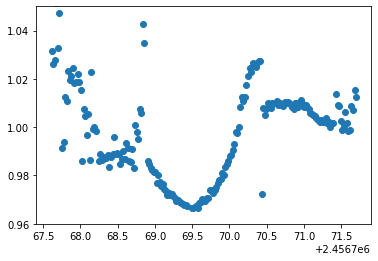

In [7]:
plt.plot(times.jd, psf_fluxes / np.median(psf_fluxes), 'o')
plt.ylim(0.96, 1.05)

(0.96, 1.05)

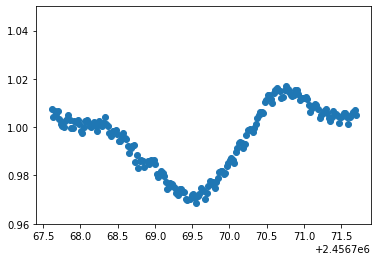

In [8]:
plt.plot(times.jd, aperture_fluxes / np.median(aperture_fluxes), 'o')
plt.ylim(0.96, 1.05)

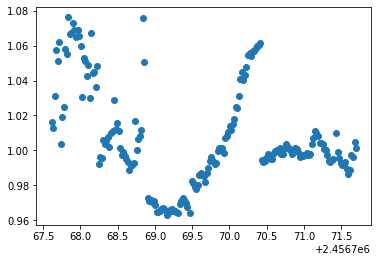

In [9]:
val = psf_fluxes + residual_fluxes
plt.plot(times.jd, val / np.median(val), 'o')

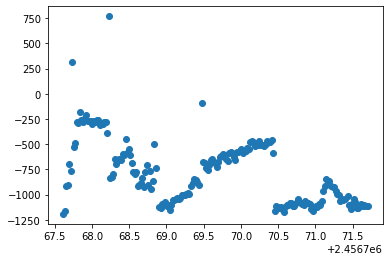

In [10]:
plt.plot(times.jd, residual_fluxes, 'o')